# Model to depixelate parts of image that were randomly pixelated.

#### The notebook is self-contained and does not import anything other than certain libraries and the final serialization file that was provided for the assignment. However, a lot of the code, especially the preparation of the dataset is the exact same code as provided during the assignments. However, certain other functions were used for various purposes and will be included with this file. Additionally, most of the cells in the notebook are also included as .py files.

Disclaimer: The notebook as well as the accompanying files include only absolute file paths. Since I used several folders during the development of the notebook, I could not easily switch to relative file paths. As a result, some of the code may not be easily reproducable.

Import libraries that are used throughout the notebook (some imported libraries may not be ultimately used but I used them for certain purposes while developing the notebook, so they are still included).

In [1]:
import numpy as np
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.optim as optim
import time
from glob import glob
from os import path
import argparse
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Write a function that turns the input image into a grayscale image as defined in the assignment. __(Same code as assignment).__

In [3]:

def to_grayscale(pil_image: np.ndarray) -> np.ndarray:
    if pil_image.ndim == 2:
        return pil_image.copy()[None]
    if pil_image.ndim != 3:
        raise ValueError("image must have either shape (H, W) or (H, W, 3)")
    if pil_image.shape[2] != 3:
        raise ValueError(f"image has shape (H, W, {pil_image.shape[2]}), but it should have (H, W, 3)")
    
    rgb = pil_image / 255
    rgb_linear = np.where(
        rgb < 0.04045,
        rgb / 12.92,
        ((rgb + 0.055) / 1.055) ** 2.4
    )
    grayscale_linear = 0.2126 * rgb_linear[..., 0] + 0.7152 * rgb_linear[..., 1] + 0.0722 * rgb_linear[..., 2]
    
    grayscale = np.where(
        grayscale_linear < 0.0031308,
        12.92 * grayscale_linear,
        1.055 * grayscale_linear ** (1 / 2.4) - 0.055
    )
    grayscale = grayscale * 255
    
    if np.issubdtype(pil_image.dtype, np.integer):
        grayscale = np.round(grayscale)
    return grayscale.astype(pil_image.dtype)[None]


The following function prepares the image as we want it, returning the pixelated image, known array and target array, as defined in the assignment. The code is mostly the same as the assignment, with one key difference. The original known array had a __False__ value for the pixelated area, and __True__ for the original area. This function returns the __exact opposite.__

In [4]:
def prepare_image(image: np.ndarray, x: int, y: int, width: int, height: int, size: int) -> \
        tuple[np.ndarray, np.ndarray, np.ndarray]:
    if image.ndim < 3 or image.shape[-3] != 1:
        # This is actually more general than the assignment specification
        raise ValueError("image must have shape (..., 1, H, W)")
    if width < 2 or height < 2 or size < 2:
        raise ValueError("width/height/size must be >= 2")
    if x < 0 or (x + width) > image.shape[-1]:
        raise ValueError(f"x={x} and width={width} do not fit into the image width={image.shape[-1]}")
    if y < 0 or (y + height) > image.shape[-2]:
        raise ValueError(f"y={y} and height={height} do not fit into the image height={image.shape[-2]}")
    
    # The (height, width) slices to extract the area that should be pixelated. Since we
    # need this multiple times, specify the slices explicitly instead of using [:] notation
    area = (..., slice(y, y + height), slice(x, x + width))
    
    # This returns already a copy, so we are independent of "image"
    pixelated_image = pixelate(image, x, y, width, height, size)
    
    known_array = np.zeros_like(image, dtype=bool)
    known_array[area] = True
    
    # Create a copy to avoid that "target_array" and "image" point to the same array
    target_array = image[area].copy()
    
    return pixelated_image, known_array, target_array


def pixelate(image: np.ndarray, x: int, y: int, width: int, height: int, size: int) -> np.ndarray:
    # Need a copy since we overwrite data directly
    image = image.copy()
    curr_x = x
    
    while curr_x < x + width:
        curr_y = y
        while curr_y < y + height:
            block = (..., slice(curr_y, min(curr_y + size, y + height)), slice(curr_x, min(curr_x + size, x + width)))
            image[block] = image[block].mean()
            curr_y += size
        curr_x += size
    
    return image


Write a custom Dataset for our assignment. This code is also very similar to the source code but it also returns the original image along with everything else. This helps us later since we don't have to recreate the original image by replacing the pixelated region with the target array.

In [5]:
class RandomImagePixelationDataset(Dataset):
    
    def __init__(
            self,
            image_dir,
            width_range: tuple[int, int],
            height_range: tuple[int, int],
            size_range: tuple[int, int]
    ):
        RandomImagePixelationDataset._check_range(width_range, "width")
        RandomImagePixelationDataset._check_range(height_range, "height")
        RandomImagePixelationDataset._check_range(size_range, "size")
        self.image_files = sorted(path.abspath(f) for f in glob(path.join(image_dir, "**", "*.jpg"), recursive=True))
        self.width_range = width_range
        self.height_range = height_range
        self.size_range = size_range
    
    @staticmethod
    def _check_range(r: tuple[int, int], name: str):
        if r[0] < 2:
            raise ValueError(f"minimum {name} must be >= 2")
        if r[0] > r[1]:
            raise ValueError(f"minimum {name} must be <= maximum {name}")
    
    def __getitem__(self, index):
        with Image.open(self.image_files[index]) as im:
            # im_shape = 64
            # resize = transforms.Resize(size=im_shape)
            # cCrop = transforms.CenterCrop(size=(im_shape, im_shape))
            # transform = transforms.Compose([resize, cCrop])
            # image_ = transform(im)
            image = np.array(im)
        image = to_grayscale(image)  # Image shape is now (1, H, W)
        image_width = image.shape[-1]
        image_height = image.shape[-2]

        
        # Create RNG in each __getitem__ call to ensure reproducibility even in
        # environments with multiple threads and/or processes
        rng = np.random.default_rng(seed=index)
        
        # Both width and height can be arbitrary, but they must not exceed the
        # actual image width and height
        width = min(rng.integers(low=self.width_range[0], high=self.width_range[1], endpoint=True), image_width)
        height = min(rng.integers(low=self.height_range[0], high=self.height_range[1], endpoint=True), image_height)
        
        # Ensure that x and y always fit with the randomly chosen width and
        # height (and not throw an error in "prepare_image")
        x = rng.integers(image_width - width, endpoint=True)
        y = rng.integers(image_height - height, endpoint=True)
        
        # Block size can be arbitrary again
        size = rng.integers(low=self.size_range[0], high=self.size_range[1], endpoint=True)
        
        pixelated_image, known_array, target_array = prepare_image(image, x, y, width, height, size)
        return image, pixelated_image, known_array, target_array
    
    def __len__(self):
        return len(self.image_files)


A custom collate_fn for the dataloader. This has some signifcant differences from the original function. It returns a tensor of the original images while also padding them to the same shape as the biggest image in the batch. However, I already transformed all images to 64x64 and saved them with the __grayscale.py__ file included with the notebook. As a result, the original images, transformed images and known arrays are all 64x64 and the transformation (or stacking) doesn't need to be performed every time. Essentially, this renders stacking these 3 somewhat useless.

However, the target arrays are now returned as 64x64 images with the target array (original image's pixelated area) broadcasted on it in the specific position it was extracted from.

__A small dataset of just 2 images is created and visualized to give a proper idea of what the function does.__

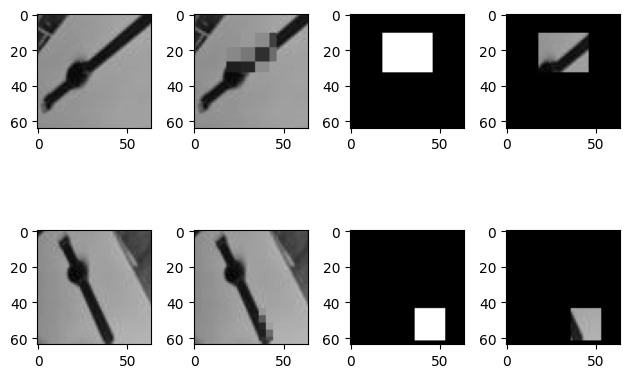

In [19]:
def stack_with_padding(batch_as_list: list):
    # Expected list elements are 4-tuples:
    # (pixelated_image, known_array, target_array, image_file)
    n = len(batch_as_list)
    shapes = []
    pixelated_images = []
    known_arrays = []
    target_arrays = []
    original_images = []
    
    for image, pixelated_image, known_array, target_array in batch_as_list:
        pixelated_images.append(pixelated_image)
        known_arrays.append(known_array)
        target_arrays.append(torch.from_numpy(target_array))
        original_images.append(torch.from_numpy(image))
        shapes.append(pixelated_image.shape)
    
    max_shape = np.max(np.stack(shapes, axis=0), axis=0)
    stacked_pixelated_images = np.zeros(shape=(n, *max_shape))
    stacked_known_arrays = np.zeros(shape=(n, *max_shape), dtype=bool)
    stacked_target_arrays = np.zeros(shape=(n, *max_shape))
    
    for i in range(n):
        channels, height, width = pixelated_images[i].shape
        stacked_pixelated_images[i, :channels, :height, :width] = pixelated_images[i]
        stacked_known_arrays[i, :channels, :height, :width] = known_arrays[i]
        coords = np.argwhere(known_arrays[i])
        _, x_min, y_min = np.min(coords, axis=0)
        _, x_max, y_max = np.max(coords, axis=0)
        stacked_target_arrays[i, :channels, x_min:x_max+1, y_min:y_max+1] = target_arrays[i]
    
    return torch.stack(original_images), torch.from_numpy(stacked_pixelated_images), torch.from_numpy(
        stacked_known_arrays), torch.from_numpy(stacked_target_arrays)

ds = RandomImagePixelationDataset(
r"C:\Users\abhir\Desktop\Assignments\Python\Python II\Project 3\Test",
width_range=(4, 32),
height_range=(4, 32),
size_range=(4, 16)
)
dl = DataLoader(ds, batch_size=2, shuffle=False, collate_fn=stack_with_padding)
for (images, pixelated_images, known_arrays, target_arrays) in dl:
    fig, axes = plt.subplots(nrows=dl.batch_size, ncols=4)
    for i in range(dl.batch_size):
        axes[i, 0].imshow(images[i].squeeze(0), cmap="gray", vmin=0, vmax=255)
        axes[i, 1].imshow(pixelated_images[i].squeeze(0), cmap="gray", vmin=0, vmax=255)
        axes[i, 2].imshow(known_arrays[i].squeeze(0), cmap="gray", vmin=0, vmax=1)
        axes[i, 3].imshow(target_arrays[i].squeeze(0), cmap="gray", vmin=0, vmax=255)
    fig.tight_layout()
    plt.show()



The next 2 cells create a dataset with the same dimensions as the test dataset was created and creates dataloader functions for the training and validation sets. The spltis are 80/20 in this case (in percentage). Additionally, the train and test sets are randomly split but uses a generator function to ensure reproducibility. This can be changed by simply removing the generator function. The training data is shuffled to ensure better learning. the validation data is not shuffled because it's not used in the calculation of the loss.

In [7]:
path_ = r"C:\Users\abhir\Desktop\Assignments\Python\Python Project\testing"
ds = RandomImagePixelationDataset(
    path_,
    width_range=(4, 32),
    height_range=(4, 32),
    size_range=(4, 16)
)

In [8]:
train_size = int(0.8*(len(ds)))
eval_size = len(ds) - train_size
train_set, validation_set = random_split(ds, [train_size, eval_size], generator=torch.Generator().manual_seed(0))
batch_size = 32
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=stack_with_padding)
valid_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=stack_with_padding)

The architecture of our NN is implemented and it also creates an instance of it and prints the total number of parameters as well as the number of trainable parameters. It is essentially the same architecture as the one in the assignment.

I tried including several more layers (MaxPool, AvgPool, Upsampling, ConvTranspose2d), but none seemed to improve performance. I also tried separate Encoder-Decoder functions but nothing seemed to work. Increasing the complexity instead made results gibberish at times. However, this could be due to not training for enough epochs. Regardless, I decided to fall back to the simplest architecture that worked.

The last layer has been changed to a Conv2d layer, instead of the linear layer in the assignment. Creating linear layers in conjunction with conv2d layers was slightly difficult since the number of out_channels in the conv2d layer had to be brought down significantly (usually to not more than 8) since the matrix multiplication could not be handled by the GPU.

In [21]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):

    def __init__(
            self,
            input_channels: int,
            hidden_channels: int,
            num_hidden_layers: int,
            use_batchnormalization: bool,
            num_classes: int,
            kernel_size: int = 3,
            activation_function: nn.Module = torch.nn.ReLU()
            ):
        super().__init__()
        hidden_layers = []
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        for _ in range(num_hidden_layers):
            layer = nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=kernel_size,
                              padding='same', padding_mode='zeros')
            hidden_layers.append(layer)
            if use_batchnormalization:
                hidden_layers.append(nn.BatchNorm2d(hidden_channels))
            hidden_layers.append(activation_function)
            input_channels = hidden_channels
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=kernel_size,
                              padding='same', padding_mode='zeros')

    def forward(self, input_images: torch.Tensor):
        x = input_images.to(device=self.device)
        x = self.hidden_layers(x)
        x = (self.output_layer(x))
        return x


model = SimpleCNN(1, 16, 5, True, 1).to(target_device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, pytorch_train_params)

9745 9745


In the beginning, the display function is imported since I wanted to visualize the outputs during the training process. Additionally, since this is perhaps the most vital part of the assignment, there are comments on all the relevant lines of code explaining what it does; the validation loop is almost identical to the training loop so it does not include these comments. Other code I used for various reasons during the process are also left in.

After this, the model is trained with the specified hyperparameters.

In [39]:
from IPython import display
def training_loop(model, dataloader): # take the model and dataloader as parameters
    model.train() # set the model to training state
    current_loss = 0
    for image, pixelated_image, known_array, target_array in dataloader: # iterate over dataloader
        known_array = known_array.to(target_device) # send the known array to the target device
        pixelated_image = pixelated_image.to(target_device) # send the pixelated image to the target device
        known_array_reverse = ~known_array.to(target_device) # reverse the known and array and send it to the target device
        
# The next line was used for the concatenating the channel dimensions of the pixelated image and the known array. However, this 
# resulted in some unexpected results and so, I commented it out.
#         input_ = (torch.cat((pixelated_image, known_array), dim=1)).float().to(target_device)
        input_ = pixelated_image.float().to(target_device) # the pixelated image again, just for naming conventions
    
# I was curious to see if the model learnt better if only presented with the pixelated region instead of the entire entire image.
# This expectedly resulted in bad predictions since the surrounding pixels are important for the predictions. 
#         input_ = input_*known_array

        input_ = torch.div(input_, 255.0) # divide the input image by 255 to normalize it between [0,1]
        output_ = model(input_) # send the normalized input to the model
        optimizer.zero_grad() # sets the optimizer gradient to zero
        target = image.float().to(target_device) # the original image is used as the target for the loss function; 
                                                 # renamed for convention
        output_ = torch.mul(output_, 255.0) # denormalize the output to [0, 255]
        
# The following code was used to visualize the outputs along with the pixelated and original images during training. 
# however, for this to work the batch size of the dataloader has to be 1. This is because it will not be able to visuallize
# stacked images. 

#         fig, axes = plt.subplots(nrows=1, ncols=3)
#         images = []
#         axes[0].imshow((output_).cpu().detach().numpy().squeeze(1).squeeze(0), cmap="gray", vmin=0, vmax=255)
#         axes[1].imshow((target).cpu().squeeze(1).squeeze(0), cmap="gray", vmin=0, vmax=255)
#         axes[2].imshow(pixelated_image.cpu().squeeze(1).squeeze(0), cmap="gray", vmin=0, vmax=255)
#         fig.tight_layout()
#         display.display(plt.gcf())

        loss = torch.sqrt(loss_function(output_*known_array, target*known_array)) # we take the square root of the 
                                                                                  # loss function (MSE). The output is 
                                                                                  # multiplied with the known array, and so is
                                                                                  # the target (original image) to ensure only 
                                                                                  # the pixelated regions are compared.
        loss.backward() # calulate the differential of the loss for the requires_grad=True model parameters
        optimizer.step() # update the model parameters
        current_loss += loss.item() # calculate the loss per batch
    train_loss = current_loss/len(dataloader.dataset) #calculate average loss for one epoch 
    print(f"Train Loss: {train_loss:.5f}") # print the average loss up to 5 decimal precision
    
    return train_loss # return the training loss

# Since the validating loop does not have any new code, the descriptions are not included with it.

def validating_loop(model, dataloader):
    model.eval()
    current_loss = 0
    with torch.no_grad():
        for image, pixelated_image, known_array, target_array in dataloader:
            known_array = known_array.to(target_device)
            pixelated_image = pixelated_image.to(target_device)
            known_array_reverse = ~known_array.to(target_device)
#             input_ = (torch.cat((pixelated_image, known_array), dim=1)).float().to(target_device)
            input_ = pixelated_image.float().to(target_device)
            input_ = torch.div(input_, 255.0)
#             input_ = input_*known_array
            output_ = model(input_)
            target = image.float().to(target_device)
            output_ = torch.mul(output_, 255.0)
            loss = torch.sqrt(loss_function(output_*known_array, target*known_array))
            current_loss += loss.item()
        test_loss = current_loss/len(dataloader.dataset)
        print(f"Test Loss: {test_loss:.5f}")
        
        return test_loss

epochs = 100
train_loss = []
val_loss = []
model = SimpleCNN(1, 16, 7, True, 1, 3).to(target_device) 
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=3,
        factor=0.5,
        verbose=True
    )
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = training_loop(model, train_dl)
    val_epoch_loss = validating_loop(model, valid_dl)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100
Train Loss: 0.22070


  1%|          | 1/100 [03:16<5:24:14, 196.51s/it]

Test Loss: 0.19742
Epoch 2 of 100
Train Loss: 0.20365


  2%|▏         | 2/100 [05:56<4:45:54, 175.04s/it]

Test Loss: 0.19767
Epoch 3 of 100
Train Loss: 0.19767


  3%|▎         | 3/100 [08:38<4:33:07, 168.95s/it]

Test Loss: 0.18622
Epoch 4 of 100
Train Loss: 0.19312


  4%|▍         | 4/100 [11:19<4:25:41, 166.06s/it]

Test Loss: 0.19274
Epoch 5 of 100
Train Loss: 0.18903


  5%|▌         | 5/100 [14:02<4:20:44, 164.67s/it]

Test Loss: 0.18825
Epoch 6 of 100
Train Loss: 0.18569


  6%|▌         | 6/100 [16:43<4:16:13, 163.55s/it]

Test Loss: 0.19324
Epoch 7 of 100
Train Loss: 0.18286


  7%|▋         | 7/100 [19:28<4:14:27, 164.16s/it]

Test Loss: 0.18783
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.
Epoch 8 of 100
Train Loss: 0.17640


  8%|▊         | 8/100 [22:02<4:06:48, 160.97s/it]

Test Loss: 0.16918
Epoch 9 of 100
Train Loss: 0.17451


  9%|▉         | 9/100 [24:38<4:01:20, 159.12s/it]

Test Loss: 0.17798
Epoch 10 of 100
Train Loss: 0.17312


 10%|█         | 10/100 [27:11<3:56:16, 157.51s/it]

Test Loss: 0.17711
Epoch 11 of 100
Train Loss: 0.17168


 11%|█         | 11/100 [29:45<3:52:00, 156.40s/it]

Test Loss: 0.16797
Epoch 12 of 100
Train Loss: 0.17023


 12%|█▏        | 12/100 [32:19<3:48:15, 155.64s/it]

Test Loss: 0.17063
Epoch 13 of 100
Train Loss: 0.16916


 13%|█▎        | 13/100 [34:54<3:45:18, 155.39s/it]

Test Loss: 0.16629
Epoch 14 of 100
Train Loss: 0.16858


 14%|█▍        | 14/100 [37:30<3:42:48, 155.45s/it]

Test Loss: 0.16368
Epoch 15 of 100
Train Loss: 0.16770


 15%|█▌        | 15/100 [40:04<3:39:40, 155.06s/it]

Test Loss: 0.16708
Epoch 16 of 100
Train Loss: 0.16724


 16%|█▌        | 16/100 [42:38<3:36:51, 154.90s/it]

Test Loss: 0.16434
Epoch 17 of 100
Train Loss: 0.16675


 17%|█▋        | 17/100 [45:13<3:34:10, 154.83s/it]

Test Loss: 0.16606
Epoch 18 of 100
Train Loss: 0.16642


 18%|█▊        | 18/100 [47:48<3:31:31, 154.77s/it]

Test Loss: 0.16327
Epoch 19 of 100
Train Loss: 0.16611


 19%|█▉        | 19/100 [50:22<3:28:44, 154.63s/it]

Test Loss: 0.16742
Epoch 20 of 100
Train Loss: 0.16580


 20%|██        | 20/100 [52:56<3:25:59, 154.50s/it]

Test Loss: 0.16269
Epoch 21 of 100
Train Loss: 0.16548


 21%|██        | 21/100 [55:31<3:23:24, 154.49s/it]

Test Loss: 0.16222
Epoch 22 of 100
Train Loss: 0.16529


 22%|██▏       | 22/100 [58:04<3:20:35, 154.31s/it]

Test Loss: 0.16192
Epoch 23 of 100
Train Loss: 0.16506


 23%|██▎       | 23/100 [1:00:39<3:18:06, 154.37s/it]

Test Loss: 0.16201
Epoch 24 of 100
Train Loss: 0.16476


 24%|██▍       | 24/100 [1:03:20<3:17:58, 156.30s/it]

Test Loss: 0.16212
Epoch 25 of 100
Train Loss: 0.16460


 25%|██▌       | 25/100 [1:05:54<3:14:40, 155.74s/it]

Test Loss: 0.16248
Epoch 26 of 100
Train Loss: 0.16441


 26%|██▌       | 26/100 [1:08:28<3:11:11, 155.02s/it]

Test Loss: 0.16275
Epoch 00026: reducing learning rate of group 0 to 2.5000e-03.
Epoch 27 of 100
Train Loss: 0.16247


 27%|██▋       | 27/100 [1:11:02<3:08:16, 154.75s/it]

Test Loss: 0.16091
Epoch 28 of 100
Train Loss: 0.16232


 28%|██▊       | 28/100 [1:13:36<3:05:27, 154.55s/it]

Test Loss: 0.16008
Epoch 29 of 100
Train Loss: 0.16218


 29%|██▉       | 29/100 [1:16:10<3:02:45, 154.44s/it]

Test Loss: 0.16056
Epoch 30 of 100
Train Loss: 0.16207


 30%|███       | 30/100 [1:18:44<3:00:08, 154.40s/it]

Test Loss: 0.15998
Epoch 31 of 100
Train Loss: 0.16195


 31%|███       | 31/100 [1:21:18<2:57:22, 154.24s/it]

Test Loss: 0.16016
Epoch 32 of 100
Train Loss: 0.16188


 32%|███▏      | 32/100 [1:23:53<2:54:59, 154.40s/it]

Test Loss: 0.15988
Epoch 33 of 100
Train Loss: 0.16174


 33%|███▎      | 33/100 [1:26:26<2:52:08, 154.16s/it]

Test Loss: 0.15982
Epoch 34 of 100
Train Loss: 0.16164


 34%|███▍      | 34/100 [1:29:01<2:49:41, 154.27s/it]

Test Loss: 0.15970
Epoch 35 of 100
Train Loss: 0.16157


 35%|███▌      | 35/100 [1:31:36<2:47:14, 154.37s/it]

Test Loss: 0.15990
Epoch 36 of 100
Train Loss: 0.16149


 36%|███▌      | 36/100 [1:34:09<2:44:18, 154.04s/it]

Test Loss: 0.16025
Epoch 37 of 100
Train Loss: 0.16139


 37%|███▋      | 37/100 [1:36:46<2:42:39, 154.92s/it]

Test Loss: 0.16149
Epoch 38 of 100
Train Loss: 0.16131


 38%|███▊      | 38/100 [1:39:21<2:40:06, 154.95s/it]

Test Loss: 0.15974
Epoch 00038: reducing learning rate of group 0 to 1.2500e-03.
Epoch 39 of 100
Train Loss: 0.16040


 39%|███▉      | 39/100 [1:41:55<2:37:13, 154.65s/it]

Test Loss: 0.15900
Epoch 40 of 100
Train Loss: 0.16030


 40%|████      | 40/100 [1:44:29<2:34:36, 154.60s/it]

Test Loss: 0.15888
Epoch 41 of 100
Train Loss: 0.16024


 41%|████      | 41/100 [1:47:03<2:31:47, 154.37s/it]

Test Loss: 0.15878
Epoch 42 of 100
Train Loss: 0.16018


 42%|████▏     | 42/100 [1:49:36<2:28:50, 153.97s/it]

Test Loss: 0.15857
Epoch 43 of 100
Train Loss: 0.16013


 43%|████▎     | 43/100 [1:52:10<2:26:10, 153.87s/it]

Test Loss: 0.15863
Epoch 44 of 100
Train Loss: 0.16008


 44%|████▍     | 44/100 [1:54:43<2:23:31, 153.78s/it]

Test Loss: 0.15876
Epoch 45 of 100
Train Loss: 0.16004


 45%|████▌     | 45/100 [1:57:17<2:20:55, 153.74s/it]

Test Loss: 0.15864
Epoch 46 of 100
Train Loss: 0.15999


 46%|████▌     | 46/100 [1:59:52<2:18:33, 153.96s/it]

Test Loss: 0.15877
Epoch 00046: reducing learning rate of group 0 to 6.2500e-04.
Epoch 47 of 100
Train Loss: 0.15950


 47%|████▋     | 47/100 [2:02:25<2:15:57, 153.92s/it]

Test Loss: 0.15828
Epoch 48 of 100
Train Loss: 0.15946


 48%|████▊     | 48/100 [2:05:05<2:14:52, 155.62s/it]

Test Loss: 0.15837
Epoch 49 of 100
Train Loss: 0.15943


 49%|████▉     | 49/100 [2:07:39<2:11:46, 155.03s/it]

Test Loss: 0.15829
Epoch 50 of 100
Train Loss: 0.15939


 50%|█████     | 50/100 [2:10:12<2:08:49, 154.59s/it]

Test Loss: 0.15823
Epoch 51 of 100
Train Loss: 0.15938


 51%|█████     | 51/100 [2:12:46<2:06:06, 154.42s/it]

Test Loss: 0.15819
Epoch 52 of 100
Train Loss: 0.15935


 52%|█████▏    | 52/100 [2:15:20<2:03:25, 154.28s/it]

Test Loss: 0.15814
Epoch 53 of 100
Train Loss: 0.15933


 53%|█████▎    | 53/100 [2:17:54<2:00:39, 154.02s/it]

Test Loss: 0.15811
Epoch 54 of 100
Train Loss: 0.15930


 54%|█████▍    | 54/100 [2:20:27<1:58:01, 153.95s/it]

Test Loss: 0.15813
Epoch 55 of 100
Train Loss: 0.15928


 55%|█████▌    | 55/100 [2:22:59<1:55:01, 153.36s/it]

Test Loss: 0.15812
Epoch 56 of 100
Train Loss: 0.15926


 56%|█████▌    | 56/100 [2:25:33<1:52:31, 153.45s/it]

Test Loss: 0.15817
Epoch 57 of 100
Train Loss: 0.15923


 57%|█████▋    | 57/100 [2:28:06<1:49:54, 153.37s/it]

Test Loss: 0.15805
Epoch 58 of 100
Train Loss: 0.15922


 58%|█████▊    | 58/100 [2:30:40<1:47:26, 153.48s/it]

Test Loss: 0.15805
Epoch 59 of 100
Train Loss: 0.15920


 59%|█████▉    | 59/100 [2:33:14<1:44:59, 153.66s/it]

Test Loss: 0.15804
Epoch 60 of 100
Train Loss: 0.15917


 60%|██████    | 60/100 [2:35:48<1:42:32, 153.81s/it]

Test Loss: 0.15803
Epoch 61 of 100
Train Loss: 0.15916


 61%|██████    | 61/100 [2:38:24<1:40:20, 154.38s/it]

Test Loss: 0.15799
Epoch 62 of 100
Train Loss: 0.15913


 62%|██████▏   | 62/100 [2:40:57<1:37:34, 154.07s/it]

Test Loss: 0.15797
Epoch 63 of 100
Train Loss: 0.15911


 63%|██████▎   | 63/100 [2:43:31<1:35:01, 154.11s/it]

Test Loss: 0.15787
Epoch 64 of 100
Train Loss: 0.15910


 64%|██████▍   | 64/100 [2:46:06<1:32:30, 154.18s/it]

Test Loss: 0.15790
Epoch 65 of 100
Train Loss: 0.15908


 65%|██████▌   | 65/100 [2:48:40<1:29:55, 154.16s/it]

Test Loss: 0.15794
Epoch 66 of 100
Train Loss: 0.15906


 66%|██████▌   | 66/100 [2:51:14<1:27:20, 154.14s/it]

Test Loss: 0.15795
Epoch 67 of 100
Train Loss: 0.15904


 67%|██████▋   | 67/100 [2:53:48<1:24:48, 154.19s/it]

Test Loss: 0.15796
Epoch 00067: reducing learning rate of group 0 to 3.1250e-04.
Epoch 68 of 100
Train Loss: 0.15880


 68%|██████▊   | 68/100 [2:56:23<1:22:18, 154.32s/it]

Test Loss: 0.15757
Epoch 69 of 100
Train Loss: 0.15878


 69%|██████▉   | 69/100 [2:58:57<1:19:44, 154.35s/it]

Test Loss: 0.15754
Epoch 70 of 100
Train Loss: 0.15876


 70%|███████   | 70/100 [3:01:32<1:17:13, 154.45s/it]

Test Loss: 0.15756
Epoch 71 of 100
Train Loss: 0.15875


 71%|███████   | 71/100 [3:04:06<1:14:34, 154.31s/it]

Test Loss: 0.15756
Epoch 72 of 100
Train Loss: 0.15874


 72%|███████▏  | 72/100 [3:06:46<1:12:49, 156.06s/it]

Test Loss: 0.15757
Epoch 73 of 100
Train Loss: 0.15872


 73%|███████▎  | 73/100 [3:09:21<1:10:01, 155.62s/it]

Test Loss: 0.15756
Epoch 00073: reducing learning rate of group 0 to 1.5625e-04.
Epoch 74 of 100
Train Loss: 0.15860


 74%|███████▍  | 74/100 [3:11:55<1:07:13, 155.13s/it]

Test Loss: 0.15739
Epoch 75 of 100
Train Loss: 0.15858


 75%|███████▌  | 75/100 [3:14:29<1:04:32, 154.89s/it]

Test Loss: 0.15739
Epoch 76 of 100
Train Loss: 0.15858


 76%|███████▌  | 76/100 [3:17:04<1:01:55, 154.80s/it]

Test Loss: 0.15739
Epoch 77 of 100
Train Loss: 0.15857


 77%|███████▋  | 77/100 [3:19:38<59:14, 154.55s/it]  

Test Loss: 0.15737
Epoch 78 of 100
Train Loss: 0.15856


 78%|███████▊  | 78/100 [3:22:12<56:37, 154.42s/it]

Test Loss: 0.15737
Epoch 79 of 100
Train Loss: 0.15856


 79%|███████▉  | 79/100 [3:24:46<54:03, 154.44s/it]

Test Loss: 0.15737
Epoch 80 of 100
Train Loss: 0.15855


 80%|████████  | 80/100 [3:27:21<51:29, 154.45s/it]

Test Loss: 0.15737
Epoch 81 of 100
Train Loss: 0.15854


 81%|████████  | 81/100 [3:29:55<48:55, 154.51s/it]

Test Loss: 0.15736
Epoch 00081: reducing learning rate of group 0 to 7.8125e-05.
Epoch 82 of 100
Train Loss: 0.15847


 82%|████████▏ | 82/100 [3:32:30<46:20, 154.45s/it]

Test Loss: 0.15728
Epoch 83 of 100
Train Loss: 0.15846


 83%|████████▎ | 83/100 [3:35:03<43:42, 154.28s/it]

Test Loss: 0.15727
Epoch 84 of 100
Train Loss: 0.15846


 84%|████████▍ | 84/100 [3:37:39<41:13, 154.59s/it]

Test Loss: 0.15727
Epoch 85 of 100
Train Loss: 0.15846


 85%|████████▌ | 85/100 [3:40:13<38:37, 154.47s/it]

Test Loss: 0.15727
Epoch 86 of 100
Train Loss: 0.15845


 86%|████████▌ | 86/100 [3:42:47<35:59, 154.22s/it]

Test Loss: 0.15727
Epoch 00086: reducing learning rate of group 0 to 3.9063e-05.
Epoch 87 of 100
Train Loss: 0.15841


 87%|████████▋ | 87/100 [3:45:21<33:25, 154.29s/it]

Test Loss: 0.15723
Epoch 88 of 100
Train Loss: 0.15841


 88%|████████▊ | 88/100 [3:47:55<30:51, 154.32s/it]

Test Loss: 0.15723
Epoch 89 of 100
Train Loss: 0.15841


 89%|████████▉ | 89/100 [3:50:30<28:17, 154.33s/it]

Test Loss: 0.15723
Epoch 90 of 100
Train Loss: 0.15840


 90%|█████████ | 90/100 [3:53:04<25:43, 154.30s/it]

Test Loss: 0.15722
Epoch 91 of 100
Train Loss: 0.15840


 91%|█████████ | 91/100 [3:55:38<23:07, 154.22s/it]

Test Loss: 0.15722
Epoch 00091: reducing learning rate of group 0 to 1.9531e-05.
Epoch 92 of 100
Train Loss: 0.15838


 92%|█████████▏| 92/100 [3:58:12<20:33, 154.13s/it]

Test Loss: 0.15720
Epoch 93 of 100
Train Loss: 0.15838


 93%|█████████▎| 93/100 [4:00:46<17:59, 154.19s/it]

Test Loss: 0.15720
Epoch 94 of 100
Train Loss: 0.15838


 94%|█████████▍| 94/100 [4:03:21<15:26, 154.33s/it]

Test Loss: 0.15720
Epoch 95 of 100
Train Loss: 0.15838


 95%|█████████▌| 95/100 [4:05:54<12:49, 153.95s/it]

Test Loss: 0.15720
Epoch 96 of 100
Train Loss: 0.15838


 96%|█████████▌| 96/100 [4:08:34<10:23, 155.82s/it]

Test Loss: 0.15720
Epoch 00096: reducing learning rate of group 0 to 9.7656e-06.
Epoch 97 of 100
Train Loss: 0.15836


 97%|█████████▋| 97/100 [4:11:09<07:46, 155.62s/it]

Test Loss: 0.15719
Epoch 98 of 100
Train Loss: 0.15836


 98%|█████████▊| 98/100 [4:13:43<05:09, 154.89s/it]

Test Loss: 0.15719
Epoch 99 of 100
Train Loss: 0.15836


 99%|█████████▉| 99/100 [4:16:16<02:34, 154.39s/it]

Test Loss: 0.15719
Epoch 100 of 100
Train Loss: 0.15836


100%|██████████| 100/100 [4:18:50<00:00, 155.31s/it]

Test Loss: 0.15719


A function is defined to plot the losses and visualize the graph. The following cell does the visualization.

In [43]:
def plot_losses(train_losses: list, eval_losses: list):
    fig, ax = plt.subplots()
    ax.plot(train_losses, label="Train loss")
    ax.plot(eval_losses, label="Eval loss")
    ax.legend()
    ax.set_xlim(0, len(train_losses) - 1)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.show()
    plt.close(fig)

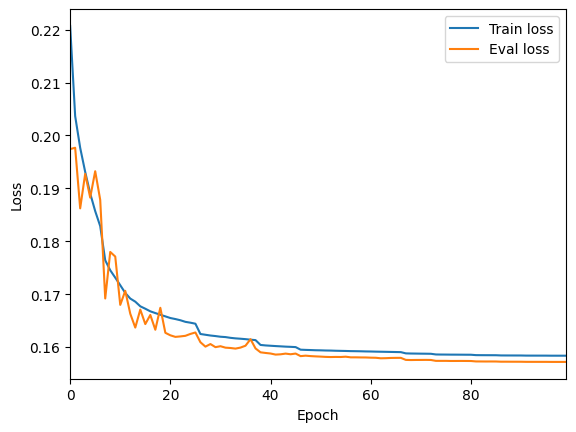

In [44]:
plot_losses(train_loss, val_loss)

Save the model parameters to a specified location. This will later be used on the test set. The entire model is not saved as the torch documentation encouraged saving only the parameters.

In [45]:
model_path = r"D:\Project\model_third.pt"
torch.save(model.state_dict(), model_path)

New dataloaders are created to visualize what the output would look like for the training data after the model is trained. Since stacked images cannot be visualized in this way, the batch size is set to 1. We then iterate over the training dataset, don't calculate the gradients or the loss and visualize the images. This helps us get an idea of how well the model performs. 

We display the prediction, original image and pixelated image from left to right.

In [73]:
train_size = int(0.8*(len(ds)))
eval_size = len(ds) - train_size
train_set, validation_set = random_split(ds, [train_size, eval_size], generator=torch.Generator().manual_seed(0))
batch_size = 1
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=False, collate_fn=stack_with_padding)
valid_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=stack_with_padding)

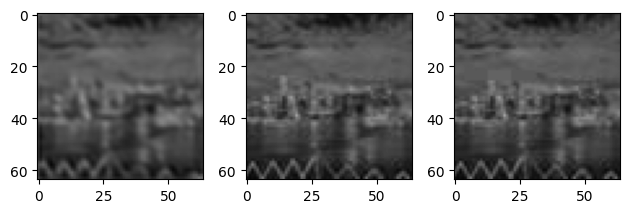

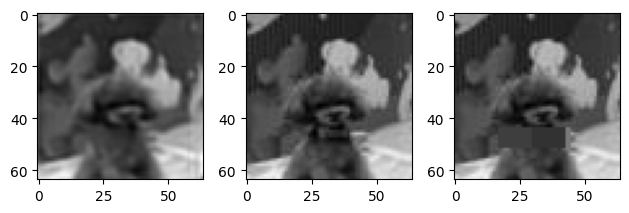

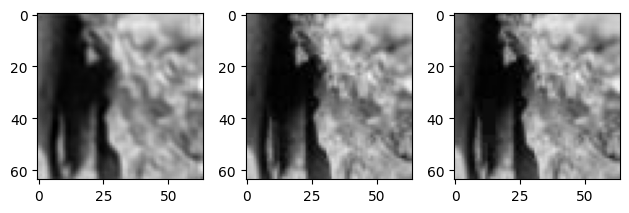

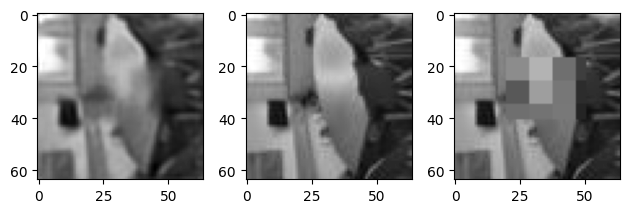

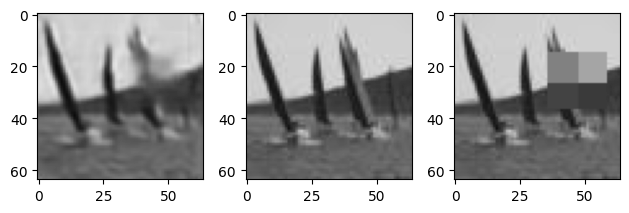

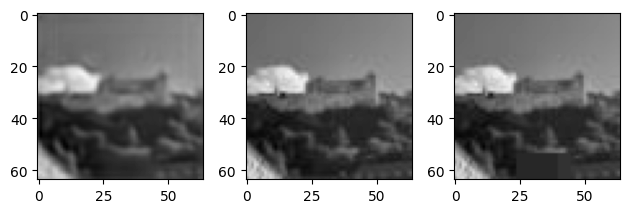

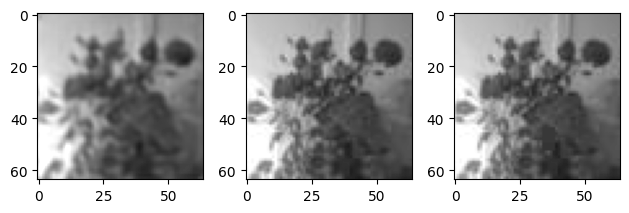

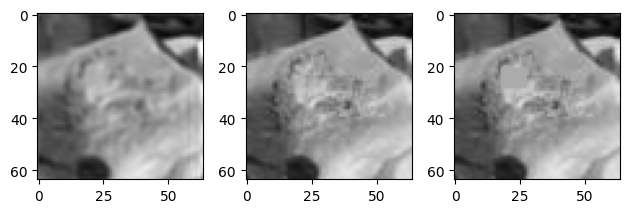

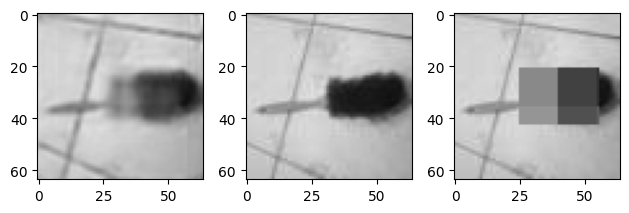

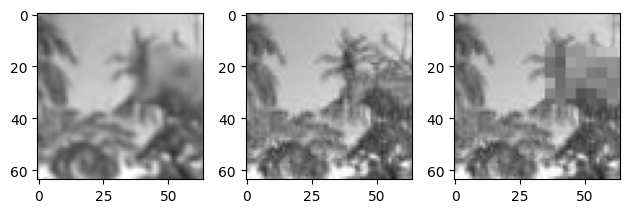

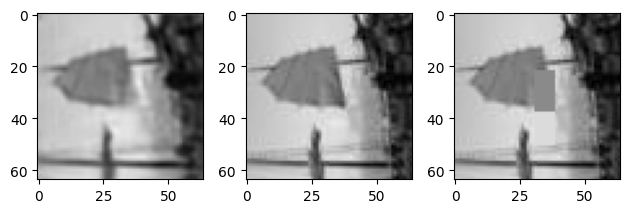

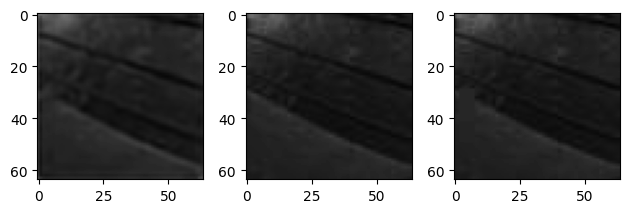

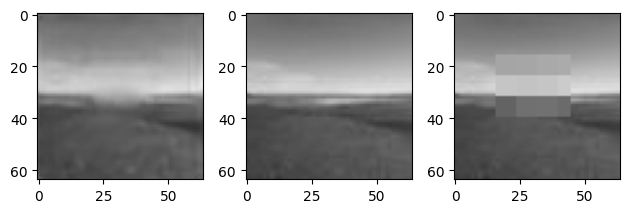

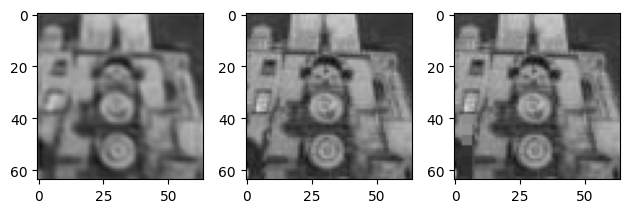

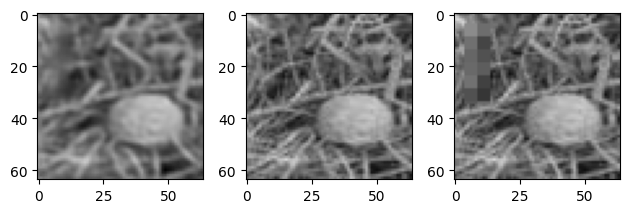

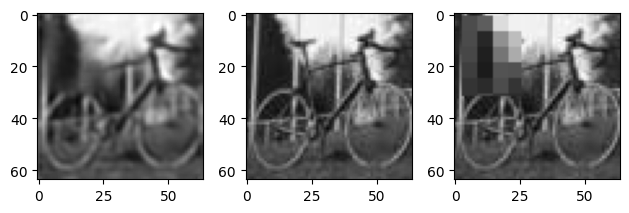

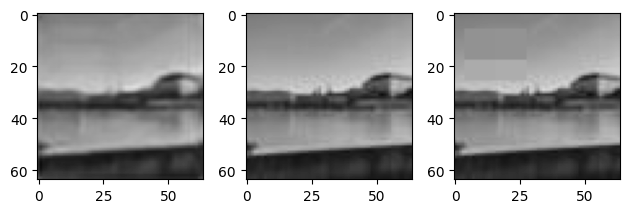

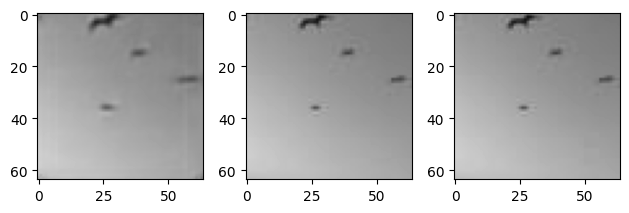

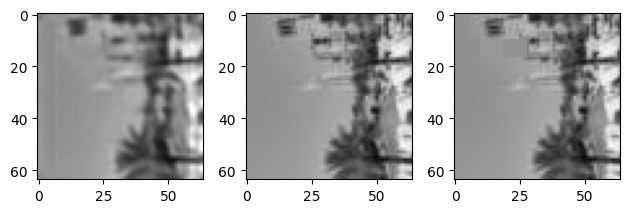

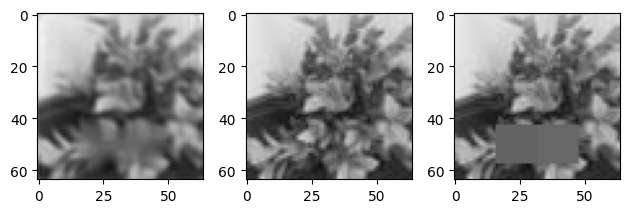

C:\Users\abhir\AppData\Local\Temp\ipykernel_20028\1260630633.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=3)


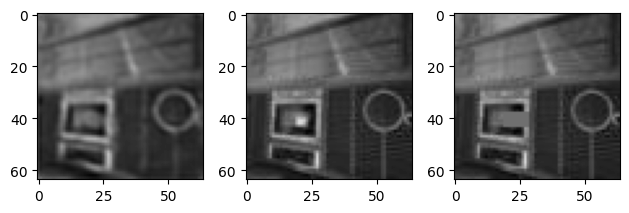

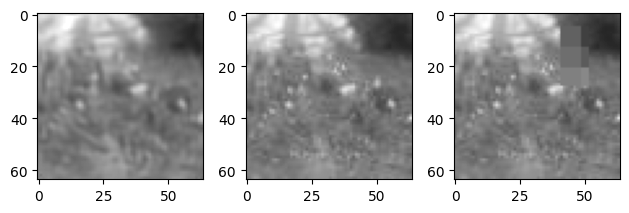

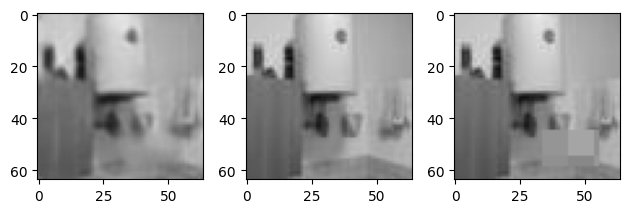

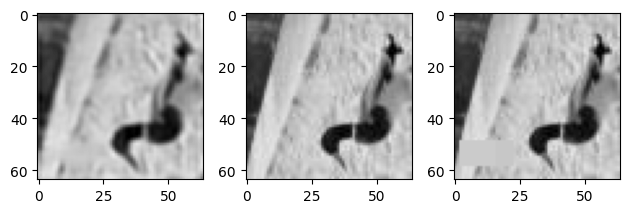

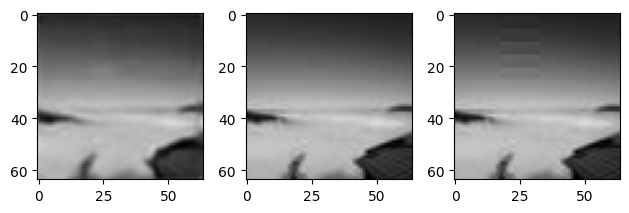

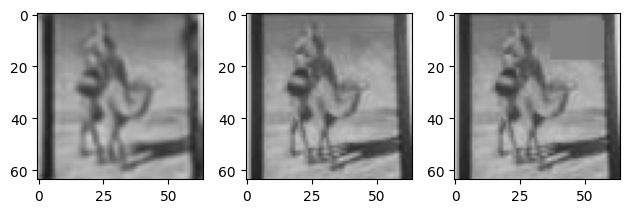

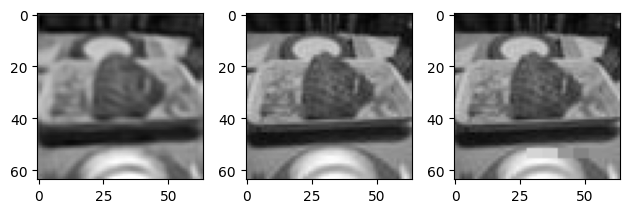

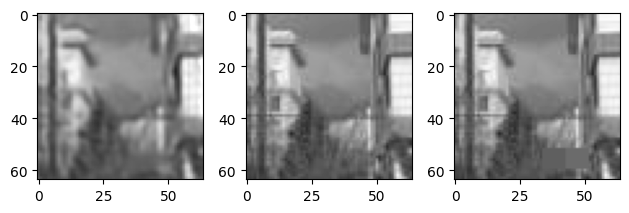

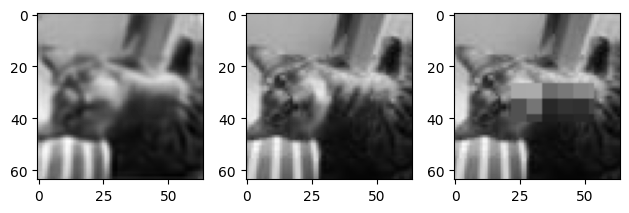

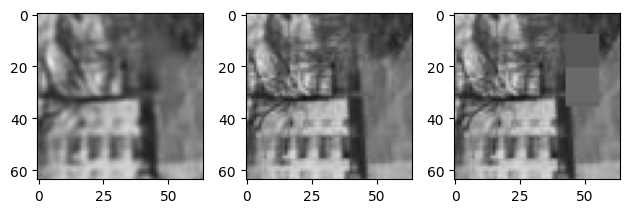

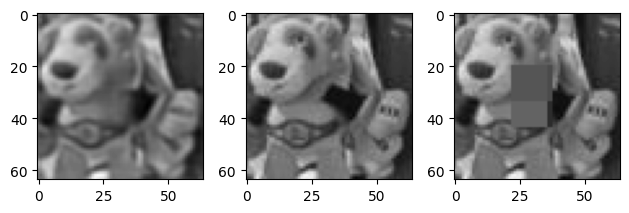

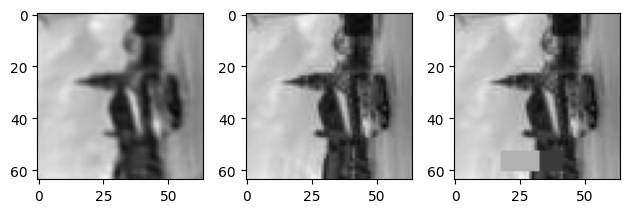

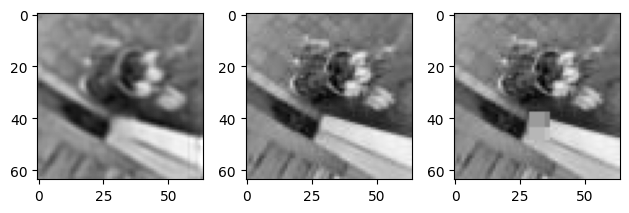

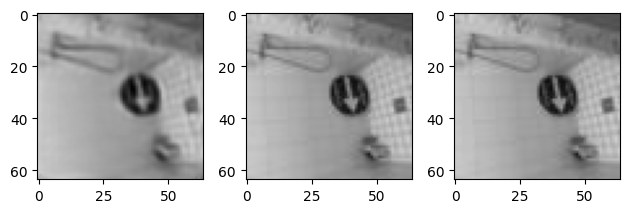

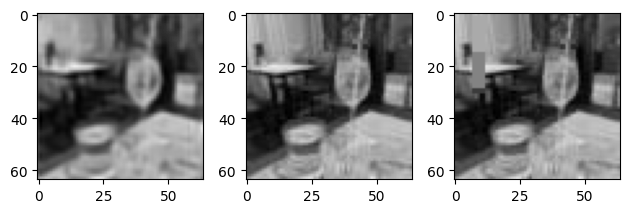

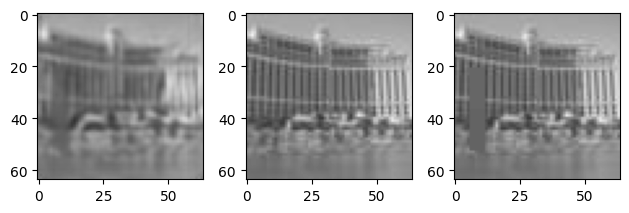

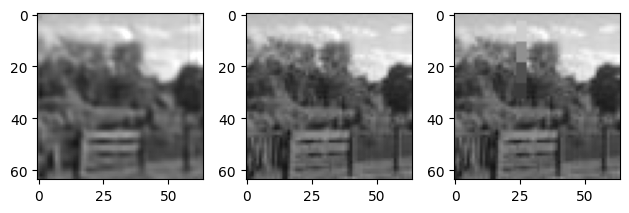

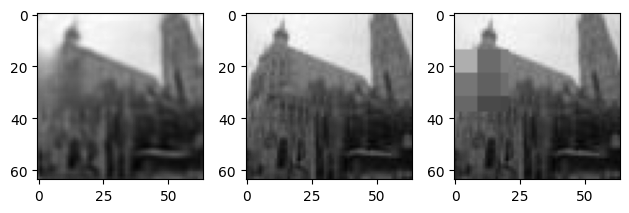

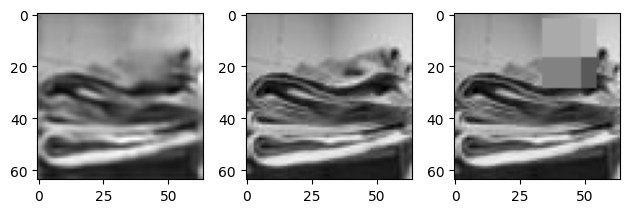

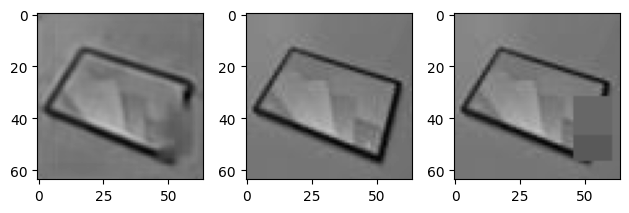

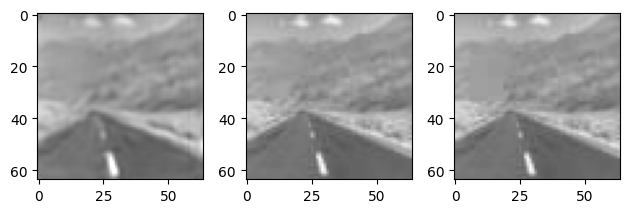

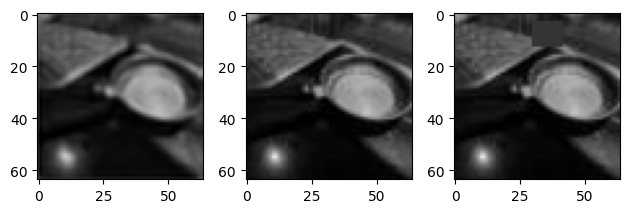

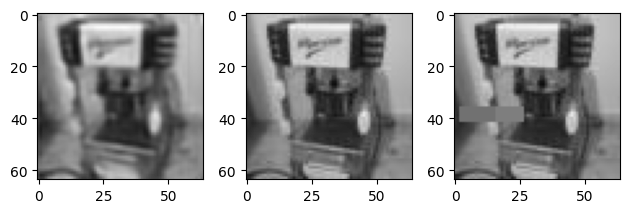

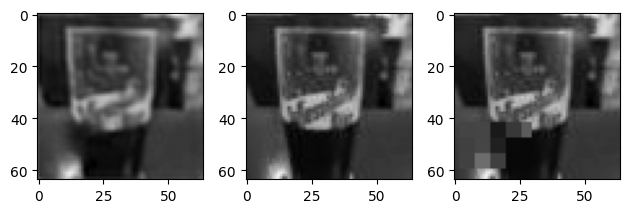

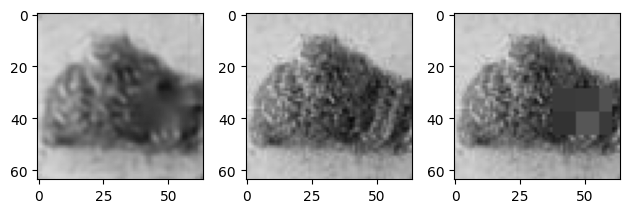

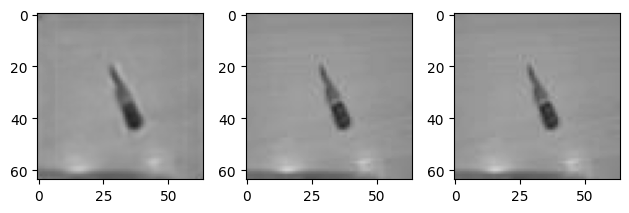

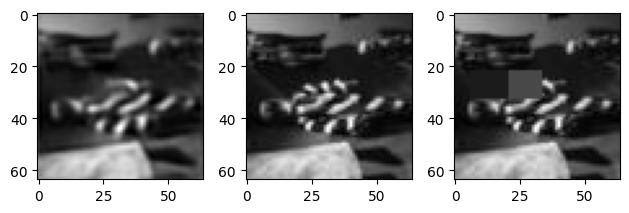

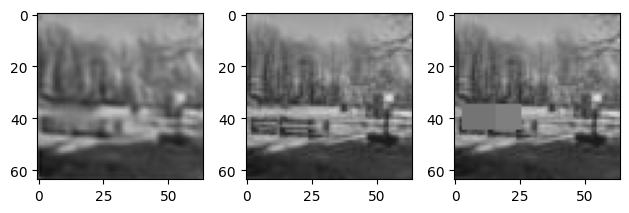

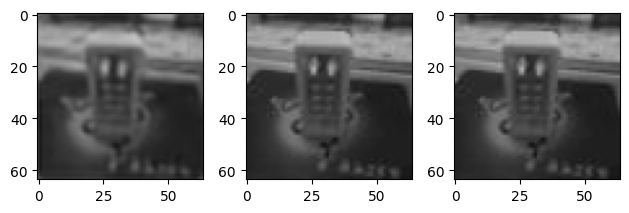

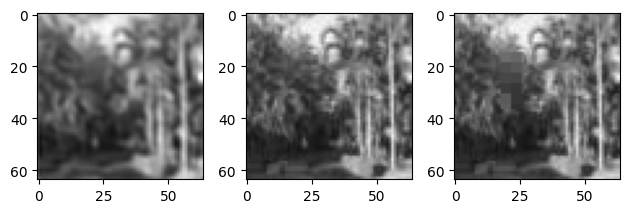

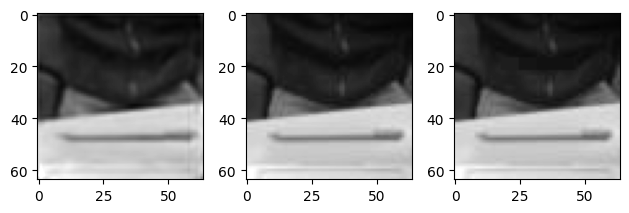

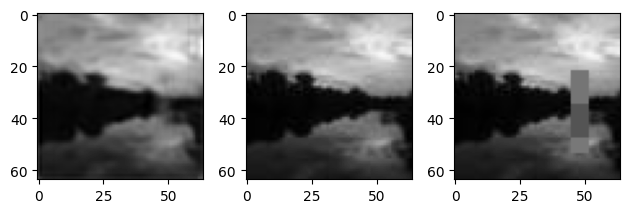

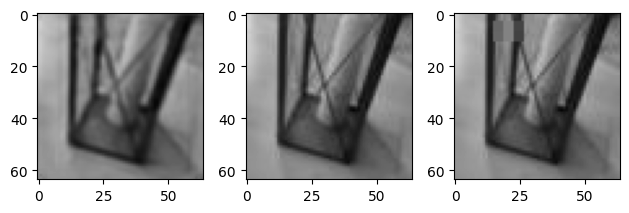

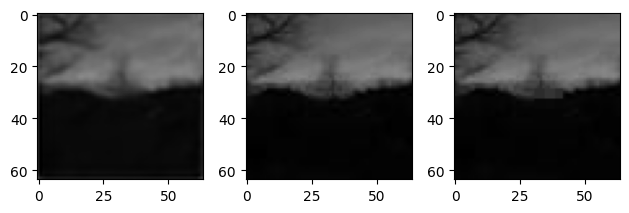

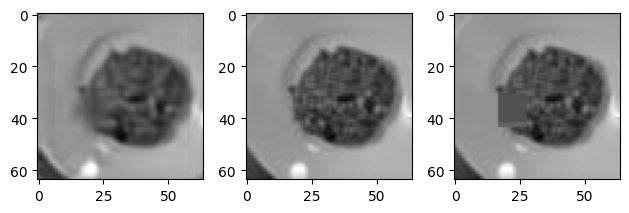

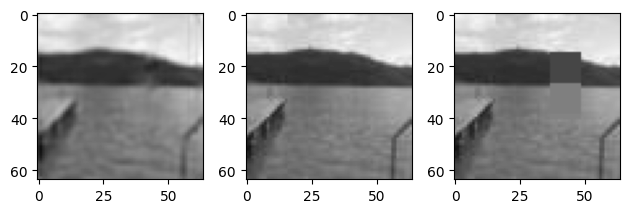

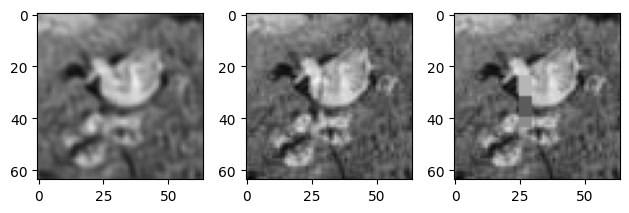

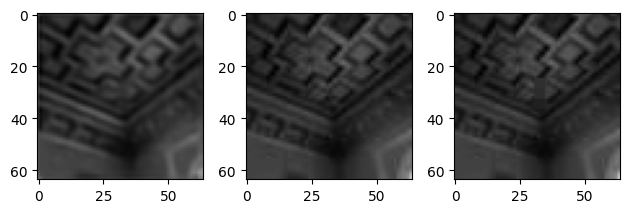

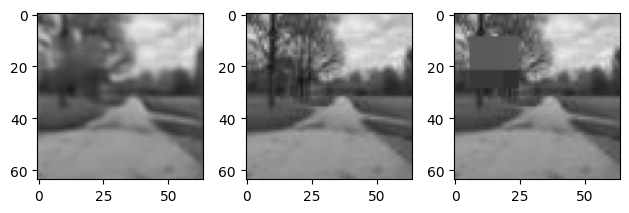

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000026C14C83430> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x0000026C3D473160> (for post_execute):


KeyboardInterrupt: 

In [75]:
path_ = r"D:\Project\model_third.pt"
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(path_))
model.eval()
model.to(target_device)

with torch.no_grad():
    for image, pixelated_image, known_array, target_array in train_dl:
            known_array = known_array.to(target_device)
            pixelated_image = pixelated_image.to(target_device)
            known_array_reverse = ~known_array.to(target_device)
    #         input_ = (torch.cat((pixelated_image, ~known_array), dim=1)).float().to(target_device)
            input_ = pixelated_image.float().to(target_device)
    #         input_ = input_*known_array
            input_ = torch.div(input_, 255.0)
            output_ = model(input_)
    #         output_ = output_[:, x_min:x_max+1, y_min:y_max+1].float().to(target_device)
            target = image.float().to(target_device)
            output_ = torch.mul(output_, 255.0)
            fig, axes = plt.subplots(nrows=1, ncols=3)
            images = []
            axes[0].imshow((output_).cpu().detach().numpy().squeeze(1).squeeze(0), cmap="gray", vmin=0, vmax=255)
            axes[1].imshow((target).cpu().squeeze(1).squeeze(0), cmap="gray", vmin=0, vmax=255)
            axes[2].imshow(pixelated_image.cpu().squeeze(1).squeeze(0), cmap="gray", vmin=0, vmax=255)
            fig.tight_layout()
            display.display(plt.gcf())

The following code simply reads the provided pickle file, stores the pixelated images and known arrays in separate lists.

It then creates an instance of the model with the same architecture as the one used to train the model, and then puts the pixelated images through the trained model and produces the output, "slicing" it with torch.masked_select to only get the pixelated region and then store that in list.

For reproduction, kindly use the model.pt file included in the zip.

In [56]:
import pickle
import torch
from tqdm import tqdm
import sys
import numpy as np
import matplotlib.pyplot as plt


np.set_printoptions(threshold=sys.maxsize)
objects = []
path_ = r"C:\Users\abhir\Desktop\Assignments\Python\Python Project\test_set.pkl"
with (open(path_, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

pixelated_images = objects[0]["pixelated_images"]
known_arrays = objects[0]["known_arrays"]
model = SimpleCNN(1, 16, 7, True, 1, 3)
path_ = r"D:\Project\model_second.pt"
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(path_))
model.eval()
model.to(target_device)
predictions = []

for pixelated_image, known_array in tqdm(zip(pixelated_images, known_arrays)):
    pixelated_image = torch.from_numpy(pixelated_image).to(target_device)
    known_array = torch.from_numpy(known_array).to(target_device)
    image = pixelated_image
    image = torch.div(image, 255.0)
#     image = torch.cat((image, ~known_array), dim=0)
    image = image.to(target_device)
    known_array_reverse = ~known_array
    coords = torch.argwhere(known_array_reverse)
    _, x_min, y_min = torch.min(coords, dim=0)[0]
    _, x_max, y_max = torch.max(coords, dim=0)[0]
    image = image.unsqueeze(0)
    output = torch.mul(model(image.float().to(target_device)), 255.0).reshape(64, 64)
#     output = torch.where(known_array == 0, output, pixelated_image)
    output = torch.masked_select(output, known_array_reverse)
    output = output.cpu().detach().numpy()
    predictions.append(output.astype("uint8"))


6635it [00:30, 219.83it/s]


The following two cells simply encode the outputs according to the provided function and then stories it in a .data file.

In [26]:
from submission_serialization import serialize

In [27]:
path_save = r"C:\Users\abhir\Desktop\Assignments\Python\Python Project" + "\\output.data"
serialize(predictions, path_save)

We once again take the test set and perform the same operations as before, except this time, we don't slice the original images. Instead, we only keep the predicted pixelated region and replace the rest of the image with the original image. This helps to visualize what the predicted area looks like for the test set.

In [10]:
import pickle
import torch
from tqdm import tqdm
import sys
import numpy as np
import matplotlib.pyplot as plt


np.set_printoptions(threshold=sys.maxsize)
objects = []
path_ = r"C:\Users\abhir\Desktop\Assignments\Python\Python Project\test_set.pkl"
with (open(path_, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

pixelated_images = objects[0]["pixelated_images"]
known_arrays = objects[0]["known_arrays"]
model = SimpleCNN(1, 16, 7, True, 1, 3)
path_ = r"D:\Project\model_third.pt"
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(path_))
model.eval()
model.to(target_device)
predictions = []

for pixelated_image, known_array in tqdm(zip(pixelated_images, known_arrays)):
    pixelated_image = torch.from_numpy(pixelated_image).to(target_device)
    known_array = torch.from_numpy(known_array).to(target_device)
    image = pixelated_image
    image = torch.div(image, 255.0)
#     image = torch.cat((image, ~known_array), dim=0)
    image = image.to(target_device)
    known_array_reverse = ~known_array
    coords = torch.argwhere(known_array_reverse)
    _, x_min, y_min = torch.min(coords, dim=0)[0]
    _, x_max, y_max = torch.max(coords, dim=0)[0]
    image = image.unsqueeze(0)
    output = torch.mul(model(image.float().to(target_device)), 255.0).reshape(64, 64)
    output = torch.where(known_array == 0, output, pixelated_image)
#     output = torch.masked_select(output, known_array_reverse)
    output = output.cpu().detach().numpy()
    predictions.append(output.astype("uint8"))


6635it [00:41, 161.52it/s]


A randomly chosen image is visualized to show the learning process.

5965


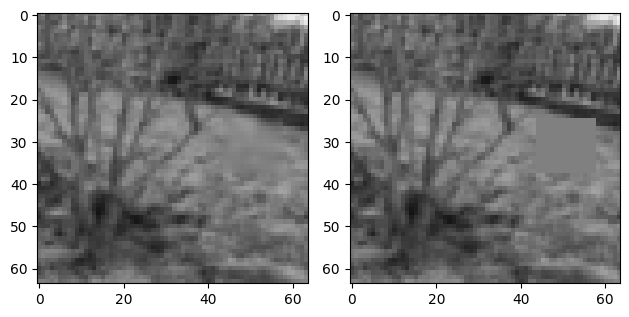

In [15]:
import random

rng_image = random.randint(0, 6000) # 6000 to make sure there is no index error
print(rng_image) # for reproducibility in case one wants to view the same image again
prediction = predictions[rng_image].reshape((64, 64))
image_ = pixelated_images[rng_image]
image_ = image_.squeeze(0)
fig, axes = plt.subplots(nrows=1, ncols=2)
images = []
axes[0].imshow(prediction, cmap="gray", vmin=0, vmax=255)
axes[1].imshow(image_, cmap="gray", vmin=0, vmax=255)
fig.tight_layout()
plt.show()